In [1]:
import torch
from gensim.models import Word2Vec
import torch.nn as nn
import cv2
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
w2v = Word2Vec.load("bare_minimum")
w2v.wv["bear"].shape

(16,)

In [3]:
w2v.wv.__len__()

10

In [13]:
bear = cv2.imread("bear.jpg")
bear = cv2.resize(bear,(128,128))
hospital = cv2.imread("hos.png")
hospital = cv2.resize(hospital,(128,128))
strike = cv2.imread("strike.jpg")
strike = cv2.resize(strike,(128,128))
imgs = np.array([(i.reshape(1,3,128,128) / 256).astype(np.float32) for i in [bear, hospital, strike]])

In [26]:
# MAKE SURE YOU ADD ANY LAYERS TO THE FORWARD FUNCTION
# THE GOAL IS COLOR
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 256, bias=False)
        # Try upscaling more linearly, but make sure it is a square number that can be upscaled by 2 to 128
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)

        self.upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up2 = nn.Conv2d(8, 16, 3, padding=1, bias=False)

        self.upsample3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up3 = nn.Conv2d(16, 4, 3, padding=1, bias=False)

        self.refine = nn.Conv2d(4, 3, 3, padding=1, bias=False)  # Extra layer to improve color
        # Try modifying the in/out channels and kernel sizes here. 
        # Can also add normal Conv layers between these, just make sure padding = kernel_size // 2
        
        self.mesh = nn.Conv2d(4, 3, 3, padding=1, bias=False)
        # Try adding additional layers here, since this is the place where
        # the current sentence image is merged with the word
        self.merge1 = nn.Conv2d(4, 3, 3, padding=1, bias=False)  # Adjust the input channels if needed
        self.merge2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)  # Adjust the input channels if needed
        
    def forward(self, word_vec, simage):
        
        x = self.dense1(word_vec)
        x = nn.functional.relu(x)
        
        x = x.reshape((-1,1,16,16))
        
        x = self.upsample1(x)
        x = nn.functional.relu(x)
        x = self.upsample2(x)
        x = nn.functional.relu(x)
        x = self.upsample3(x)
        x = nn.functional.relu(x) # <- This activation function should result in something image-like, relu isn't great
        
        # Make modifications here too
        
        x = torch.concat((simage, x), dim=1)
        x = self.merge1(x)
        x = nn.functional.relu(x)
        x = self.merge2(x)
        return nn.functional.sigmoid(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1, bias=False)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1, bias=False)
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(266,128, bias=False)
        self.classify2 = nn.Linear(128,64, bias=False)
        self.classify3 = nn.Linear(64, 10, bias=False)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1, bias=False)
        self.next2 = nn.Conv2d(16,16,3,padding=1, bias=False)
        self.next3 = nn.Conv2d(16, 3, 1, bias=False)
        
        
    def forward(self, input, context):
        
        x = self.conv1(input)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.relu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.relu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.relu(c)

        c = self.flatten(c)
        c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.relu(c)
        c = self.classify2(c)
        c = nn.functional.relu(c)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = nn.functional.relu(n)
        n = self.next2(n)
        n = nn.functional.relu(n)
        n = self.next3(n)
        n = nn.functional.sigmoid(n)
        
        return c, n

In [27]:
torch.manual_seed(42)
enc = Encoder()
dec = Decoder()

In [28]:
a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))
dec(a, torch.zeros(1,10))

(tensor([[-2.1912e-05,  2.2641e-06, -1.9499e-06, -7.0344e-06,  1.5037e-05,
           1.2720e-05,  4.1282e-07,  1.5250e-05,  7.0952e-06,  2.4842e-05]],
        grad_fn=<MmBackward0>),
 tensor([[[[0.5001, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.4999],
           [0.5001, 0.5000, 0.5000,  ..., 0.4999, 0.5001, 0.4997],
           [0.5002, 0.5000, 0.5000,  ..., 0.4998, 0.5003, 0.4997],
           ...,
           [0.5002, 0.5001, 0.5001,  ..., 0.4998, 0.5002, 0.4997],
           [0.5003, 0.5001, 0.5001,  ..., 0.4998, 0.5002, 0.4996],
           [0.5002, 0.4998, 0.5001,  ..., 0.4997, 0.5001, 0.4999]],
 
          [[0.5001, 0.5001, 0.5001,  ..., 0.5001, 0.5003, 0.5001],
           [0.5003, 0.5001, 0.5004,  ..., 0.5004, 0.5005, 0.5001],
           [0.5004, 0.5002, 0.5006,  ..., 0.5005, 0.5006, 0.5003],
           ...,
           [0.5004, 0.5003, 0.5006,  ..., 0.5006, 0.5005, 0.5004],
           [0.5005, 0.5003, 0.5003,  ..., 0.5003, 0.5008, 0.5003],
           [0.5003, 0.5001, 0.5002,  ..., 0.

In [29]:
sentences = [["the", "bear", "is", "eating", "honey"],
             ["where", "is", "the", "hospital"],
             ["students", "are", "striking"]]
images = torch.tensor(imgs)

In [30]:
# define optim
crit_words = nn.CrossEntropyLoss()
crit_image = nn.MSELoss()

s = nn.ModuleList([enc,dec])

optim = torch.optim.Adam(s.parameters())

In [31]:
## Training loop
epochs = 500
for epoch in range(epochs):
    sents = []
    for img,sent in zip(images,sentences):
        optim.zero_grad()
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        # Try modifying weights or training scheme
        loss = crit_image(img, canvas)
        pic = canvas.clone()
        context = torch.zeros(1,10)
        outs = []
        for w in sent:
            word, canvas = dec(canvas, context)
            context = word
            loss = loss + crit_words(word, torch.tensor([w2v.wv.key_to_index[w]]))
            outs.append(word)
        loss.backward()
        optim.step()
        sents.append(outs)

In [32]:
[[w2v.wv.index_to_key[w.argmax()] for w in sen] for sen in sents]

[['the', 'bear', 'is', 'eating', 'honey'],
 ['where', 'is', 'the', 'hospital'],
 ['students', 'are', 'striking']]

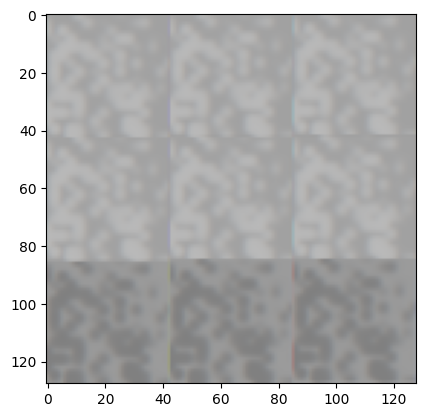

In [33]:
imshow(nn.functional.sigmoid(pic).detach().numpy().reshape(128,128,3))

In [34]:
pic[:,:,0] - pic[:,:,2]

tensor([[[-4.1537e-02, -9.7542e-02, -7.7174e-02, -6.8657e-02, -6.1493e-02,
          -5.3757e-02, -4.5946e-02, -3.8567e-02, -3.2732e-02, -2.9220e-02,
          -2.7688e-02, -2.7235e-02, -2.7072e-02, -2.7171e-02, -2.7451e-02,
          -2.7752e-02, -2.7882e-02, -2.7720e-02, -2.7352e-02, -2.6886e-02,
          -2.6421e-02, -2.5938e-02, -2.5414e-02, -2.7602e-02, -3.3487e-02,
          -4.6966e-02, -6.4898e-02, -8.6398e-02, -1.0695e-01, -1.2519e-01,
          -1.3910e-01, -1.4654e-01, -1.5022e-01, -1.5118e-01, -1.5326e-01,
          -1.5488e-01, -1.5671e-01, -1.5743e-01, -1.5676e-01, -1.5376e-01,
          -1.4749e-01, -1.3897e-01, -1.2821e-01, -1.1721e-01, -1.0584e-01,
          -9.4879e-02, -8.4074e-02, -7.3830e-02, -6.4425e-02, -5.6336e-02,
          -4.9879e-02, -4.4967e-02, -4.1451e-02, -3.9257e-02, -3.8271e-02,
          -3.8256e-02, -3.8770e-02, -3.9334e-02, -3.9611e-02, -3.9482e-02,
          -3.8962e-02, -3.8065e-02, -3.6804e-02, -3.5347e-02, -3.3949e-02,
          -3.3050e-02, -3